# Feature Engineering + Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import re
import datetime
%matplotlib inline

In [2]:
train = pd.read_csv('../data/train_merged.csv')
test = pd.read_csv('../data/test_merged.csv')

In [3]:
train.head()

,game_date,home_team,away_team,home_score,away_score,tournament,country,neutral,overall_diff,attack_away_defence_home_diff,...,bup_passing_diff,bup_speed_diff,cc_crossing_diff,cc_passing_diff,cc_shooting_diff,d_aggresion_diff,d_pressure_diff,d_width_diff,home_win,gdp_diff
0,2006-09-01 00:00:00+00:00,Denmark,Portugal,4,2,Friendly,Denmark,False,-3.0,3.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1,1.639666
1,2006-10-11 00:00:00+00:00,Poland,Portugal,2,1,UEFA Euro qualification,Poland,False,-7.0,10.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1,0.966720
2,2006-09-06 00:00:00+00:00,Finland,Portugal,1,1,UEFA Euro qualification,Finland,False,-7.0,9.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0,1.455813
3,2006-10-07 00:00:00+00:00,Denmark,Northern Ireland,0,0,UEFA Euro qualification,Denmark,False,9.0,-11.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0,0.683074
4,2006-10-11 00:00:00+00:00,Austria,Switzerland,2,1,Friendly,Austria,False,-3.0,4.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1,0.802591


We first need to see for matches that are not neutral (i.e. home team is actually playing at home), if playing at home actually is an advantage. 

In [4]:
#First make sure there are no "away" teams in own country.
train[train['away_team'] == train['country']]

,game_date,home_team,away_team,home_score,away_score,tournament,country,neutral,overall_diff,attack_away_defence_home_diff,...,bup_passing_diff,bup_speed_diff,cc_crossing_diff,cc_passing_diff,cc_shooting_diff,d_aggresion_diff,d_pressure_diff,d_width_diff,home_win,gdp_diff


In [5]:
print("Proportion of Outcomes")
train.groupby('home_win')['game_date'].count() / len(train)

Proportion of Outcomes


home_win
-1    0.301529
 0    0.260411
 1    0.438060
Name: game_date, dtype: float64

In [6]:
print("Proportion of Outcomes Grouped By Neutrality")
train.groupby(['neutral', 'home_win'])['game_date'].count() / train.groupby(['neutral'])['game_date'].count()

Proportion of Outcomes Grouped By Neutrality


neutral  home_win
False    -1          0.284536
          0          0.270103
          1          0.445361
True     -1          0.357466
          0          0.228507
          1          0.414027
Name: game_date, dtype: float64

Surprisingly, it seems that being at home actually does not give an advantage! 

From the European matches we saw that past match results might be good features. As such, we do the same thing here and calculate the number of wins by the home team and away team and the past matches. 


In [7]:
train_sorted = train.sort_values(by = 'game_date').reset_index(drop = True)

In [8]:
def get_wins_in_last_matches(df_row, df, num_games, team_id_col = ['home_team', 'away_team'],
                            against_each_other = False):
    """
    Get number of wins for home team and away team for num_games before current game. Also includes 
    indicators of whether the team has played enough games (for the matches in the beginning). If against_each_other
    is True, get number of wins home team has against away team had in past num_games.
    
    Also returns the number of games actually found.
    """

    home_team_id_colname = team_id_col[0]
    away_team_id_colname = team_id_col[1]
    if not against_each_other:

        #Get past games for both home and away teams.
        home_past_games = df[((df[home_team_id_colname] == df_row[home_team_id_colname])\
                            | (df[away_team_id_colname] == df_row[home_team_id_colname]))\
                             & (df.game_date < df_row.game_date)][-num_games:]
        away_past_games = df[((df[home_team_id_colname]== df_row[away_team_id_colname])\
                            | (df[away_team_id_colname] == df_row[away_team_id_colname]))\
                             & (df.game_date < df_row.game_date)][-num_games:]
        #get actual number of games found 
        
        
        #get number of wins for home team 
        home_wins = 0
        for index, game in home_past_games.iterrows():
            if game[home_team_id_colname] == df_row[home_team_id_colname] and game.home_win == 1:
                home_wins += 1
            elif game[away_team_id_colname] == df_row[home_team_id_colname] and game.home_win == 0:
                home_wins += 1

        #get number of wins for away team         
        away_wins = 0
        for index, game in away_past_games.iterrows():
            if game[home_team_id_colname] == df_row[away_team_id_colname] and game.home_win == 1:
                away_wins += 1
            elif game[away_team_id_colname] == df_row[away_team_id_colname] and game.home_win == 0:
                away_wins += 1
        return (home_wins, away_wins, len(home_past_games), len(away_past_games))
    else:
        #get past games where the two teams played against each other
        past_games = df[(((df[home_team_id_colname] == df_row[home_team_id_colname])\
                            & (df[away_team_id_colname] == df_row[away_team_id_colname]))\
                        | ((df[home_team_id_colname] == df_row[away_team_id_colname])
                        & (df[away_team_id_colname] == df_row[home_team_id_colname])))
                        & (df.game_date < df_row.game_date)][-num_games:]
        wins = 0
        for index, game in past_games.iterrows():
            #home team wins in past game against away team as home team
            if game[home_team_id_colname] == df_row[home_team_id_colname] and game.home_win == 1:
                wins += 1
            #home team wins in past game against away team as away team
            elif game[away_team_id_colname] == df_row[home_team_id_colname] and game.home_win == 0:
                wins += 1
        return (wins, len(past_games))

In [9]:
wins_past_x_games = {}
for index, row in train_sorted.iterrows():
    for i in range(1, 6):
        if i not in wins_past_x_games.keys():
            wins_past_x_games[i] = []
        wins_past_x_games[i].append(get_wins_in_last_matches(row, train_sorted, i))

In [10]:
wins_past_x_games_df = pd.DataFrame(index = train_sorted.index)
for i in range(1, 6):
    wins_past_x_games_df = wins_past_x_games_df.merge(
            pd.DataFrame(wins_past_x_games[i], index = train_sorted.index,\
             columns = ['home_wins_past_{}_games'.format(i), 'away_wins_past_{}_games'.format(i), \
                        'home_num_past_games_{}'.format(i), 'away_num_past_games_{}'.format(i)]),\
                        left_index = True, right_index = True)


In [11]:
#against each other
wins_home_against_away_past_x_games = {}
for index, row in train_sorted.iterrows():
    for i in range(1, 6):
        if i not in wins_home_against_away_past_x_games.keys():
            wins_home_against_away_past_x_games[i] = []
        wins_home_against_away_past_x_games[i].append(get_wins_in_last_matches(row, train_sorted, i, 
                                                                                against_each_other=True))

In [12]:
wins_home_against_away_past_x_games_df = pd.DataFrame(index = train_sorted.index)
for i in range(1, 6):
    wins_home_against_away_past_x_games_df = wins_home_against_away_past_x_games_df.merge(
            pd.DataFrame(wins_home_against_away_past_x_games[i], index = train_sorted.index,\
            columns = ['wins_home_against_away_{}_games'.format(i), 'num_past_games_{}'.format(i),]),\
                        left_index = True, right_index = True)


In [13]:
past_wins_columns = []
for i in range(1, 6):
    wins_past_x_games_df['wins_past_{}_games_diff'.format(i)] =\
        (wins_past_x_games_df['home_wins_past_{}_games'.format(i)] -\
         wins_past_x_games_df['away_wins_past_{}_games'.format(i)])
    past_wins_columns.append('wins_past_{}_games_diff'.format(i))
#     past_wins_columns.append('home_num_past_games{}'.format(i))
    #games against each other
    wins_past_x_games_df['wins_home_against_away_{}_games'.format(i)] = \
                            wins_home_against_away_past_x_games_df['wins_home_against_away_{}_games'.format(i)]
    past_wins_columns.append('wins_home_against_away_{}_games'.format(i))

past_wins_columns

['wins_past_1_games_diff',
 'wins_home_against_away_1_games',
 'wins_past_2_games_diff',
 'wins_home_against_away_2_games',
 'wins_past_3_games_diff',
 'wins_home_against_away_3_games',
 'wins_past_4_games_diff',
 'wins_home_against_away_4_games',
 'wins_past_5_games_diff',
 'wins_home_against_away_5_games']

In [14]:
train_final = train_sorted.copy()
train_final[past_wins_columns] = wins_past_x_games_df[past_wins_columns]
train_final.tail()

,game_date,home_team,away_team,home_score,away_score,tournament,country,neutral,overall_diff,attack_away_defence_home_diff,...,wins_past_1_games_diff,wins_home_against_away_1_games,wins_past_2_games_diff,wins_home_against_away_2_games,wins_past_3_games_diff,wins_home_against_away_3_games,wins_past_4_games_diff,wins_home_against_away_4_games,wins_past_5_games_diff,wins_home_against_away_5_games
1892,2018-06-09 00:00:00+00:00,Tunisia,Spain,0,1,Friendly,Russia,True,-13.0,12.0,...,1,0,1,0,0,0,-1,0,-2,0
1893,2018-06-10 00:00:00+00:00,Austria,Brazil,0,3,Friendly,Austria,False,-8.0,11.0,...,1,0,2,0,3,0,3,0,3,0
1894,2018-06-11 00:00:00+00:00,Korea Republic,Senegal,0,2,Friendly,Austria,True,-3.0,7.0,...,0,0,0,0,0,0,0,0,0,0
1895,2018-06-11 00:00:00+00:00,Belgium,Costa Rica,4,1,Friendly,Belgium,False,11.0,-16.0,...,1,0,0,0,1,0,1,0,1,0
1896,2018-06-12 00:00:00+00:00,Japan,Paraguay,4,2,Friendly,Austria,True,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0


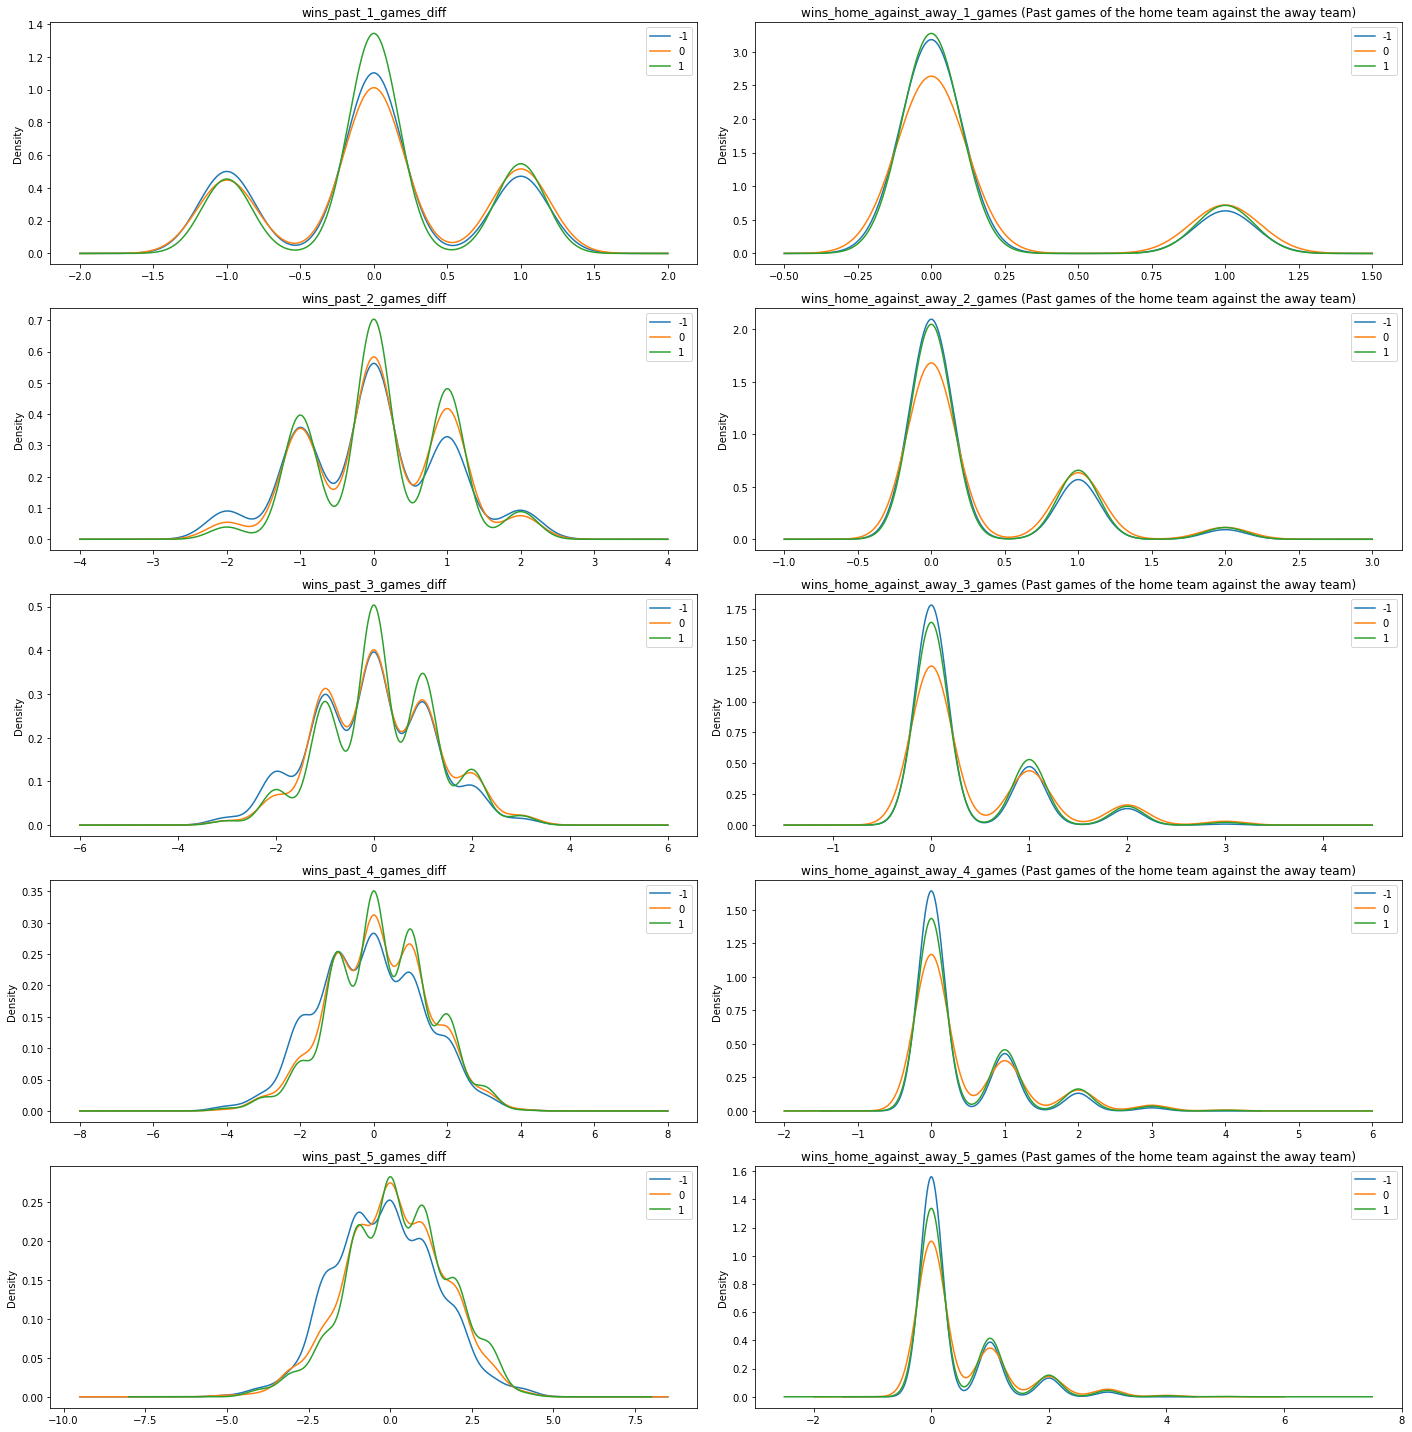

In [15]:
fig, axes = plt.subplots(5, 2, figsize = (20, 20))
axes = axes.flatten()
for label, df in train_final.groupby('home_win'):
    for i, col in enumerate(past_wins_columns):
        df[col].plot.kde(label=label, ax = axes[i])
        #odd plots are the plots of the teams against each other
        if i % 2 == 1:
            axes[i].set_title(col + " (Past games of the home team against the away team)")
        else:
            axes[i].set_title(col)
        axes[i].legend()
plt.tight_layout();

We realized that the test set is already sorted by earliest game in the tournament to latest game. Since we will not be using date for any of the features besides calculating past wins, we can just for the test set set each match to be one day after the other and it will not affect anything.

In [16]:
test['game_date'] = [datetime.datetime(2018,6, 14) + datetime.timedelta(days=i) for i in range(64)] 

In [17]:
wins_past_x_games = {}
for index, row in test.iterrows():
    for i in range(1, 6):
        if i not in wins_past_x_games.keys():
            wins_past_x_games[i] = []
        wins_past_x_games[i].append(get_wins_in_last_matches(row, test, i))

In [18]:
wins_past_x_games_df = pd.DataFrame(index = test.index)
for i in range(1, 6):
    wins_past_x_games_df = wins_past_x_games_df.merge(
            pd.DataFrame(wins_past_x_games[i], index = test.index,\
             columns = ['home_wins_past_{}_games'.format(i), 'away_wins_past_{}_games'.format(i), \
                        'home_num_past_games_{}'.format(i), 'away_num_past_games_{}'.format(i)]),\
                        left_index = True, right_index = True)

In [19]:
#against each other
wins_home_against_away_past_x_games = {}
for index, row in test.iterrows():
    for i in range(1, 6):
        if i not in wins_home_against_away_past_x_games.keys():
            wins_home_against_away_past_x_games[i] = []
        wins_home_against_away_past_x_games[i].append(get_wins_in_last_matches(row, test, i, 
                                                                                against_each_other=True))

In [20]:
wins_home_against_away_past_x_games_df = pd.DataFrame(index = test.index)
for i in range(1, 6):
    wins_home_against_away_past_x_games_df = wins_home_against_away_past_x_games_df.merge(
            pd.DataFrame(wins_home_against_away_past_x_games[i], index = test.index,\
            columns = ['wins_home_against_away_{}_games'.format(i), 'num_past_games_{}'.format(i),]),\
                        left_index = True, right_index = True)


In [21]:
past_wins_columns = []
for i in range(1, 6):
    wins_past_x_games_df['wins_past_{}_games_diff'.format(i)] =\
        (wins_past_x_games_df['home_wins_past_{}_games'.format(i)] -\
         wins_past_x_games_df['away_wins_past_{}_games'.format(i)])
    past_wins_columns.append('wins_past_{}_games_diff'.format(i))
#     past_wins_columns.append('home_num_past_games{}'.format(i))
    #games against each other
    wins_past_x_games_df['wins_home_against_away_{}_games'.format(i)] = \
                            wins_home_against_away_past_x_games_df['wins_home_against_away_{}_games'.format(i)]
    past_wins_columns.append('wins_home_against_away_{}_games'.format(i))

past_wins_columns

['wins_past_1_games_diff',
 'wins_home_against_away_1_games',
 'wins_past_2_games_diff',
 'wins_home_against_away_2_games',
 'wins_past_3_games_diff',
 'wins_home_against_away_3_games',
 'wins_past_4_games_diff',
 'wins_home_against_away_4_games',
 'wins_past_5_games_diff',
 'wins_home_against_away_5_games']

In [22]:
test_final = test.copy()
test_final[past_wins_columns] = wins_past_x_games_df[past_wins_columns]
test_final.tail()

,game_date,home_team,away_team,home_score,away_score,tournament,country,neutral,overall_diff,attack_away_defence_home_diff,...,wins_past_1_games_diff,wins_home_against_away_1_games,wins_past_2_games_diff,wins_home_against_away_2_games,wins_past_3_games_diff,wins_home_against_away_3_games,wins_past_4_games_diff,wins_home_against_away_4_games,wins_past_5_games_diff,wins_home_against_away_5_games
59,2018-08-12,Russia,Croatia,2,2,FIFA World Cup,Russia,False,-1.0,4.0,...,-1,0,0,0,1,0,1,0,1,0
60,2018-08-13,France,Belgium,1,0,FIFA World Cup,Russia,True,2.0,4.0,...,0,0,0,0,1,0,1,0,1,0
61,2018-08-14,Croatia,England,2,1,FIFA World Cup,Russia,True,-1.0,5.0,...,0,0,1,0,1,0,0,0,1,0
62,2018-08-15,Belgium,England,2,0,FIFA World Cup,Russia,True,2.0,0.0,...,0,0,0,0,1,0,1,0,1,0
63,2018-08-16,France,Croatia,4,2,FIFA World Cup,Russia,True,5.0,0.0,...,0,0,0,0,0,0,1,0,2,0


In [23]:
train_final.to_csv('../data/cleaned/train_final.csv', index = False)
test_final.to_csv('../data/cleaned/test_final.csv', index = False)